# Real or Not? NLP with Disaster Tweets


## 1. Introduction

In this notebook, we will be training a BERT Model.

* Bag of Words 
* TF IDF
* GloVe
* BERT with TFHub and with Submission
* PCA visualization for the main models
* Showing Confusion Matrices for BERT and GloVe


## 2. Import libraries 
The below code intializes hyperparameters of the model.

In [30]:
random_state_split = 42
Dropout_num = 0
learning_rate = 6e-6
valid = 0.2
epochs_num = 3
batch_size_num = 16
target_corrected = False
target_big_corrected = False

In [43]:
import random
random.seed(42)

import numpy as np
np.random.seed(42)

import tensorflow as tf
tf.random.set_seed(42)

import pandas as pd
import numpy as np
import os

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from nltk.corpus import stopwords
from nltk.util import ngrams

from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import classification_report,confusion_matrix

from collections import defaultdict
from collections import Counter
plt.style.use('ggplot')
stop=set(stopwords.words('english'))

import re
from nltk.tokenize import word_tokenize
import gensim
import string

from tqdm import tqdm
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM,Dense, SpatialDropout1D, Dropout
from keras.initializers import Constant
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

## 3. Load data 
The below code loads the data and prints the shape of Train and Test.

In [ ]:
tweet = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
submission = pd.read_csv("./sample_submission.csv")

print('There are {} rows and {} columns in train'.format(tweet.shape[0],tweet.shape[1]))
print('There are {} rows and {} columns in train'.format(test.shape[0],test.shape[1]))

tweet.head(10)

## 3. Data Cleaning
To clean the freetext in Text column, we will be doing the below steps:
1. Remove urls.
2. Remove HTML Tags
3. Remove Emojis
4. Remove punctuations

In [ ]:
df=pd.concat([tweet,test], sort=False)

#Removing urls
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

df['text']=df['text'].apply(lambda x : remove_URL(x))

#Removing HTML tags
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

df['text']=df['text'].apply(lambda x : remove_html(x))

# Removing Emojis
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

df['text']=df['text'].apply(lambda x: remove_emoji(x))

# Removing punctuations
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

df['text']=df['text'].apply(lambda x : remove_punct(x))

## 4. word embedding- transformation from words to vectors.

The challenge with textual data is that it needs to be represented in a format that can be mathematically used in solving some problem. In simple words, we need to get an integer representation of a word.

### 4.1 Bag of Words
One of the common techniques used is Bag of Words Counts which is implemented in **Scikit-learn’s CountVectorizer**. This is used to transform a corpora of text to a vector of term / token counts. The output of the CountVectorizer is a Sparse Matrix. Each column in the matrix represents a unique word in the vocabulary, while each row represents the sample(or document) in our dataset.

Later, we will visualize the embeddings. We are using truncated SVD for Dimensionality reduction and plotting the components.

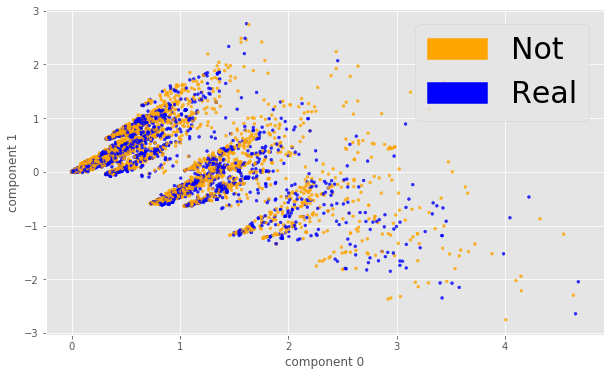

In [47]:
def cv(data):
    count_vectorizer = CountVectorizer()

    emb = count_vectorizer.fit_transform(data)

    return emb, count_vectorizer

list_corpus = df["text"].tolist()
list_labels = df["target"].tolist()

X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, 
                                                                                random_state=random_state_split)

X_train_counts, count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)

def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            orange_patch = mpatches.Patch(color='orange', label='Not')
            blue_patch = mpatches.Patch(color='blue', label='Real')
            plt.legend(handles=[orange_patch, blue_patch], prop={'size': 30})
            plt.xlabel("component 0")
            plt.ylabel("component 1")

fig = plt.figure(figsize=(10, 6))          
plot_LSA(X_train_counts, y_train)

These embeddings shown above don't look very cleanly separated. Let's see if we can use a different Vectorizer.

### 4.2. TF IDF

TF-IDF converts a collection of raw documents to a matrix of TF-IDF features. This is an acronym that stands for “Term Frequency – Inverse Document” Frequency which is a product of the below scores assigned to each word.

1. **Term Frequency**: This summarizes how often a given word appears within a document.
   $$TF(t) = (Number_of_times_term_t_appears_in_a_document) / (Total_number_of_terms_in_the_document)$$
2. **Inverse Document Frequency**: This downscales words that appear a lot across documents.
   $$IDF(t) = log_e(Total_number_of_documents / Number_of_documents_with_term_t_in_it$$

This weight is a statistical measure used to evaluate how important a word is to a document in a collection or corpus. The importance increases proportionally to the number of times a word appears in the document but is offset by the frequency of the word in the corpus. 

The scores are normalized to values between 0 and 1 and the encoded document vectors can then be used directly with most machine learning algorithms.

Later, we will visualize the embeddings. We are using truncated SVD for Dimensionality reduction and plotting the components.

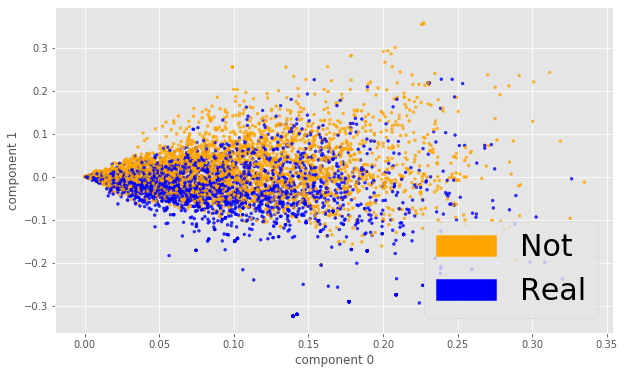

In [48]:
def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer()

    train = tfidf_vectorizer.fit_transform(data)

    return train, tfidf_vectorizer

X_train_tfidf, tfidf_vectorizer = tfidf(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

fig = plt.figure(figsize=(10, 6))          
plot_LSA(X_train_tfidf, y_train)

These embeddings shown above still don't look very cleanly separated.

## 4.3. GloVe Embeddings

GloVe is an acronym for Global Vectors for Word Representation. This allows us to take a corpus of text, and intuitively transform each word in that corpus into a position in a high-dimensional space which means that similar words will be placed together.

The first task is to download pre-trained word vectors that is available in 3 varieties : 50D, 100D and 200 Dimensional. We will try 100D here. Before we load the vectors in code, we have to understand how the text file is formatted.
Each line of the text file contains a word, followed by N numbers. The N numbers describe the vector of the word’s position. N may vary depending on which vectors is downloaded, for us, N is 100, since we are using glove.6B.100d.

Below is the summary of tasks if the below code:
1. parse the GloVe vectors file and build the dictionary of it's vectors. 
2. text is split into words using word_tokenize to build the corpus.
3. build the dictionary consisting of unique words from the corpus.
4. create embedding vectors for each sample in Train with maximum length of 50 words.

In [50]:
embedding_dict={}
with open('../input/glove-global-vectors-for-word-representation/glove.6B.100d.txt','r') as f:
    for line in f:
        values=line.split()
        word = values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
f.close()


def create_corpus_new(df):
    corpus=[]
    for tweet in tqdm(df['text']):
        words=[word.lower() for word in word_tokenize(tweet)]
        corpus.append(words)
    return corpus 

corpus=create_corpus_new(df)

100%|██████████| 10876/10876 [00:03<00:00, 3531.75it/s]


In [53]:
MAX_LEN=50
tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(corpus)
sequences=tokenizer_obj.texts_to_sequences(corpus)

tweet_pad=pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')

word_index=tokenizer_obj.word_index
print('Number of unique words:',len(word_index))

Number of unique words: 22807


In [54]:
num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,100))

for word,i in tqdm(word_index.items()):
    if i < num_words:
        emb_vec=embedding_dict.get(word)
        if emb_vec is not None:
            embedding_matrix[i]=emb_vec           

100%|██████████| 22807/22807 [00:00<00:00, 321017.93it/s]


## 5. Baseline Model with GloVe results
In the below section we will build a network and train it using GloVe features as the inputs.

In [57]:
model=Sequential()

embedding=Embedding(num_words,100,embeddings_initializer=Constant(embedding_matrix),
                   input_length=MAX_LEN,trainable=False)

model.add(embedding)
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

optimzer=Adam(learning_rate=3e-4)

model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 100)           2280800   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 50, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 2,361,301
Trainable params: 80,501
Non-trainable params: 2,280,800
_________________________________________________________________


In [59]:
train=tweet_pad[:tweet.shape[0]]
test=tweet_pad[tweet.shape[0]:]

X_train,X_test,y_train,y_test=train_test_split(train,tweet['target'].values,test_size=0.2)
print('Shape of train',X_train.shape)
print("Shape of Validation ",X_test.shape)

Shape of train (6090, 50)
Shape of Validation  (1523, 50)


In [61]:

earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint('.glove100Dmodel.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='min')

history=model.fit(X_train,y_train,batch_size=4,epochs=10,validation_data=(X_test,y_test),verbose=2, callbacks = [reduce_lr_loss,mcp_save,earlyStopping])

Train on 6090 samples, validate on 1523 samples
Epoch 1/10
 - 78s - loss: 0.5753 - accuracy: 0.7202 - val_loss: 0.5131 - val_accuracy: 0.7669
Epoch 2/10
 - 78s - loss: 0.5257 - accuracy: 0.7663 - val_loss: 0.5806 - val_accuracy: 0.7715
Epoch 3/10
 - 76s - loss: 0.5255 - accuracy: 0.7609 - val_loss: 0.5315 - val_accuracy: 0.7479
Epoch 4/10
 - 76s - loss: 0.5085 - accuracy: 0.7675 - val_loss: 0.4910 - val_accuracy: 0.7866
Epoch 5/10
 - 77s - loss: 0.5153 - accuracy: 0.7695 - val_loss: 0.4930 - val_accuracy: 0.7892
Epoch 6/10
 - 78s - loss: 0.4918 - accuracy: 0.7864 - val_loss: 0.5089 - val_accuracy: 0.7787
Epoch 7/10
 - 77s - loss: 0.5007 - accuracy: 0.7754 - val_loss: 0.5122 - val_accuracy: 0.7643
Epoch 8/10
 - 78s - loss: 0.4992 - accuracy: 0.7869 - val_loss: 0.4885 - val_accuracy: 0.7748
Epoch 9/10
 - 79s - loss: 0.5320 - accuracy: 0.7388 - val_loss: 0.4895 - val_accuracy: 0.7781
Epoch 10/10
 - 78s - loss: 0.5309 - accuracy: 0.7514 - val_loss: 0.5086 - val_accuracy: 0.7689


In [62]:
train_pred_GloVe = model.predict(train)
train_pred_GloVe_int = train_pred_GloVe.round().astype('int')

## 10. BERT using TFHub

In [ ]:
# https://www.kaggle.com/shahules/basic-eda-cleaning-and-glove
# https://www.kaggle.com/xhlulu/disaster-nlp-keras-bert-using-tfhub
# thanks
# https://www.kaggle.com/rftexas/text-only-kfold-bert

In [63]:
# We will use the official tokenization script created by the Google team
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

In [64]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub

import tokenization

In [65]:
# Thanks to https://www.kaggle.com/xhlulu/disaster-nlp-keras-bert-using-tfhub

def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [66]:

def build_model(bert_layer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    
    if Dropout_num == 0:
        # Without Dropout
        out = Dense(1, activation='sigmoid')(clf_output)
    else:
        # With Dropout(Dropout_num), Dropout_num > 0
        x = Dropout(Dropout_num)(clf_output)
        out = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(Adam(lr=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

## Big target correction

In [68]:
def clean_tweets(tweet):
    """Removes links and non-ASCII characters"""
    
    tweet = ''.join([x for x in tweet if x in string.printable])
    
    # Removing URLs
    tweet = re.sub(r"http\S+", "", tweet)
    
    return tweet

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_punctuations(text):
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`"
    
    for p in punctuations:
        text = text.replace(p, f' {p} ')

    text = text.replace('...', ' ... ')
    
    if '...' not in text:
        text = text.replace('..', ' ... ')
    
    return text

In [70]:
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

def convert_abbrev(word):
    return abbreviations[word.lower()] if word.lower() in abbreviations.keys() else word

def convert_abbrev_in_text(text):
    tokens = word_tokenize(text)
    tokens = [convert_abbrev(word) for word in tokens]
    text = ' '.join(tokens)
    return text

## Download data

In [73]:
# Load BERT from the Tensorflow Hub
module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1"
bert_layer = hub.KerasLayer(module_url, trainable=True)

In [74]:
# Load CSV files containing training data
train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

## Target correction

In [75]:
# Thanks to https://www.kaggle.com/wrrosa/keras-bert-using-tfhub-modified-train-data - 
# author of this kernel read tweets in training data and figure out that some of them have errors:
if target_corrected:
    ids_with_target_error = [328,443,513,2619,3640,3900,4342,5781,6552,6554,6570,6701,6702,6729,6861,7226]
    train.loc[train['id'].isin(ids_with_target_error),'target'] = 0
    train[train['id'].isin(ids_with_target_error)]

In [76]:
# Thanks to https://www.kaggle.com/rftexas/text-only-kfold-bert
if target_big_corrected:
    train["text"] = train["text"].apply(lambda x: clean_tweets(x))
    test["text"] = test["text"].apply(lambda x: clean_tweets(x))
    
    train["text"] = train["text"].apply(lambda x: remove_emoji(x))
    test["text"] = test["text"].apply(lambda x: remove_emoji(x))
    
    train["text"] = train["text"].apply(lambda x: remove_punctuations(x))
    test["text"] = test["text"].apply(lambda x: remove_punctuations(x))
    
    train["text"] = train["text"].apply(lambda x: convert_abbrev_in_text(x))
    test["text"] = test["text"].apply(lambda x: convert_abbrev_in_text(x))

In [77]:
print(target_big_corrected)
print(target_corrected)

False
False


## Build and train BERT model

In [78]:
# Thanks to https://www.kaggle.com/xhlulu/disaster-nlp-keras-bert-using-tfhub
# Load tokenizer from the bert layer
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [79]:
# Thanks to https://www.kaggle.com/xhlulu/disaster-nlp-keras-bert-using-tfhub
# Encode the text into tokens, masks, and segment flags
train_input = bert_encode(train.text.values, tokenizer, max_len=160)
test_input = bert_encode(test.text.values, tokenizer, max_len=160)
train_labels = train.target.values

In [80]:
# Thanks to https://www.kaggle.com/xhlulu/disaster-nlp-keras-bert-using-tfhub
# Build BERT model with my tuning
model_BERT = build_model(bert_layer, max_len=160)
model_BERT.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 160)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 160)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 160)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 1024), (None 335141889   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [81]:
# Thanks to https://www.kaggle.com/xhlulu/disaster-nlp-keras-bert-using-tfhub
# Train BERT model with my tuning
checkpoint = ModelCheckpoint('model_BERT.h5', monitor='val_loss', save_best_only=True)

train_history = model_BERT.fit(
    train_input, train_labels,
    validation_split = valid,
    epochs = epochs_num, # recomended 3-5 epochs
    callbacks=[checkpoint],
    batch_size = batch_size_num,
)

Train on 6090 samples, validate on 1523 samples
Epoch 1/3
6090/6090 [==============================] - 437s 72ms/sample - loss: 0.4313 - accuracy: 0.8117 - val_loss: 0.3680 - val_accuracy: 0.8418
Epoch 2/3
6090/6090 [==============================] - 354s 58ms/sample - loss: 0.2801 - accuracy: 0.8924 - val_loss: 0.4629 - val_accuracy: 0.8188
Epoch 3/3
6090/6090 [==============================] - 354s 58ms/sample - loss: 0.1478 - accuracy: 0.9489 - val_loss: 0.4599 - val_accuracy: 0.8273


## Prediction

In [82]:
# Thanks to https://www.kaggle.com/xhlulu/disaster-nlp-keras-bert-using-tfhub
# Prediction by BERT model with my tuning
model_BERT.load_weights('model_BERT.h5')
test_pred_BERT = model_BERT.predict(test_input)
test_pred_BERT_int = test_pred_BERT.round().astype('int')

In [83]:
# Prediction by BERT model with tuning for the training data - for the Confusion Matrix
train_pred_BERT = model_BERT.predict(train_input)
train_pred_BERT_int = train_pred_BERT.round().astype('int')

### 10.1. Submission by BERT<a class="anchor" id="10.1"></a>

[Back to Table of Contents](#0.1)

Thanks to https://www.kaggle.com/xhlulu/disaster-nlp-keras-bert-using-tfhub

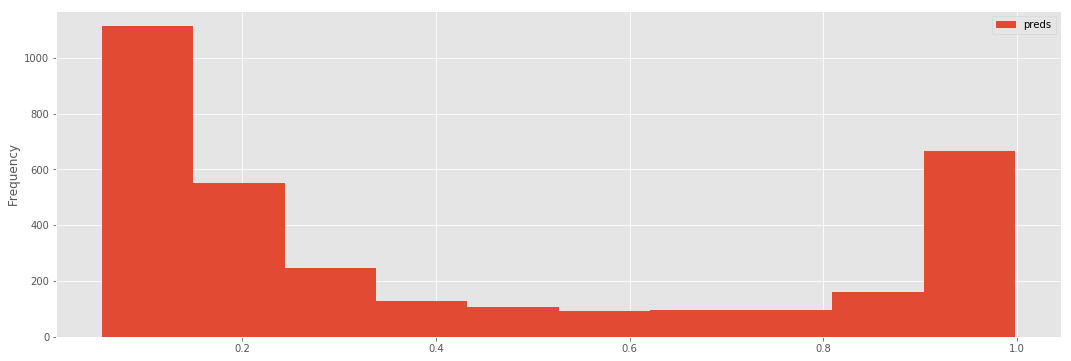

In [84]:
pred = pd.DataFrame(test_pred_BERT, columns=['preds'])
pred.plot.hist()

In [85]:
submission['target'] = test_pred_BERT_int
submission.head(10)

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
5,12,1
6,21,0
7,22,0
8,27,0
9,29,0


In [86]:
submission.to_csv("submission_bert_bow_tfidf_glove_tfhubbert.csv", index=False, header=True)

## 11. Showing Confusion Matrices<a class="anchor" id="11"></a>

[Back to Table of Contents](#0.1)

Thanks to https://www.kaggle.com/marcovasquez/basic-nlp-with-tensorflow-and-wordcloud

In [87]:
# Showing Confusion Matrix
def plot_cm(y_true, y_pred, title, figsize=(5,5)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    plt.title(title)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)

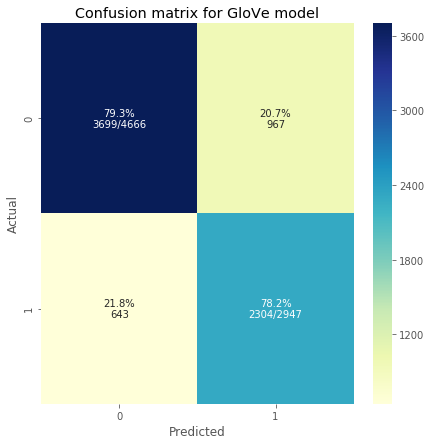

In [88]:
# Showing Confusion Matrix for GloVe model
plot_cm(train_pred_GloVe_int, train['target'].values, 'Confusion matrix for GloVe model', figsize=(7,7))

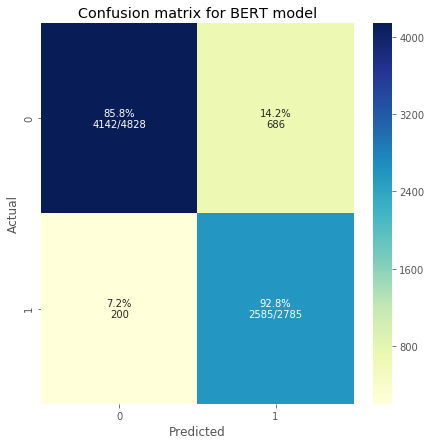

In [89]:
# Showing Confusion Matrix for BERT model
plot_cm(train_pred_BERT_int, train['target'].values, 'Confusion matrix for BERT model', figsize=(7,7))

I hope you find this kernel useful and enjoyable.

Your comments and feedback are most welcome.

[Go to Top](#0)